In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
import os
import numpy as np
import tensorflow as tf

In [3]:
def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    return image, label

IMG_SIZE = 160

train_dataset = tf.keras.utils.image_dataset_from_directory(
      "../gdrive/MyDrive/Colab_data/dog-cat-full-dataset-master/data/train", image_size=(IMG_SIZE, IMG_SIZE),
      validation_split=0.1, subset="training", shuffle=True,
      seed=42, batch_size=32
)

valid_dataset = tf.keras.utils.image_dataset_from_directory(
    "../gdrive/MyDrive/Colab_data/dog-cat-full-dataset-master/data/train", image_size=(IMG_SIZE, IMG_SIZE),
    validation_split=0.1, subset="validation", shuffle=True,
    seed=42, batch_size=32
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    "../gdrive/MyDrive/Colab_data/dog-cat-full-dataset-master/data/test", image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True, seed=42, batch_size=32
)

Found 20000 files belonging to 2 classes.
Using 18000 files for training.
Found 20000 files belonging to 2 classes.
Using 2000 files for validation.
Found 5000 files belonging to 2 classes.


In [4]:
def format_sample(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    return image, label

train_dataset = train_dataset.map(format_sample)
valid_dataset = valid_dataset.map(format_sample)
test_dataset = test_dataset.map(format_sample)

In [5]:
## Create the base model from the pre-trained model MobileNet V2 using our IMG_SHAPE as the input_shape
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

9406464/9406464 [==============================] - 0s 0us/step


In [6]:
base_model.trainable = False

In [7]:
## Pass our image_batch to the model, the feature_batch is what we get.
image_batch,label_batch = next(iter(train_dataset.take(1)))
feature_batch = base_model(image_batch)
print(feature_batch.shape)
print(label_batch.shape)

(32, 5, 5, 1280)
(32,)


In [10]:
print(label_batch)

tf.Tensor([1 1 0 1 0 1 1 1 0 0 1 0 1 0 1 0 0 1 1 1 0 0 0 0 1 0 0 0 1 0 1 1], shape=(32,), dtype=int32)


In [8]:
## Add a global_average_layer to pool the output from `MobileNet` to transfer the knowledge for our problem.
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
## Add prediction layer for the actual prediction.
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch)
print(prediction_batch.shape)

tf.Tensor(
[[ 1.174092  ]
 [-0.7799332 ]
 [-0.04429118]
 [ 0.59004074]
 [ 0.41916153]
 [-0.34397227]
 [ 0.48887646]
 [-0.18179089]
 [ 0.886479  ]
 [ 1.4218807 ]
 [ 0.39132118]
 [ 0.72522366]
 [-0.4462911 ]
 [ 1.2121621 ]
 [-1.1436921 ]
 [ 1.626904  ]
 [ 0.8635612 ]
 [ 0.7891967 ]
 [ 1.1852908 ]
 [ 0.8830319 ]
 [-0.5993893 ]
 [-0.31320685]
 [-0.8860512 ]
 [ 1.5405531 ]
 [-1.0252849 ]
 [-0.7984792 ]
 [ 2.3898902 ]
 [ 0.34648913]
 [-0.8602195 ]
 [ 0.02056497]
 [ 0.495289  ]
 [-0.90901494]], shape=(32, 1), dtype=float32)
(32, 1)


In [ ]:
## Combine the base_model and the two newly added layers together.
x = base_model.output;
x = global_average_layer(x)
x = prediction_layer(x)

model = tf.keras.Model(inputs=base_model.input,outputs=x)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[0][0]']        

In [ ]:
## Setup learning rate, optimizer and loss function
base_learning_rate = 0.0001

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
	loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
	metrics=['accuracy']
)

In [ ]:
## Try to use valid_dataset to avoid overfitting.
initial_epochs = 2 # please try `initial_epochs = 10` or `initial_epochs = 20` after `initial_epochs = 2` is okay
validation_steps=20

loss0,accuracy0 = model.evaluate(valid_dataset, steps = validation_steps)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

20/20 [==============================] - 66s 2s/step - loss: 0.7912 - accuracy: 0.4734
initial loss: 0.79
initial accuracy: 0.47


In [ ]:
import keras

loss_result = []
accuracy_result = []

class PerBatchMetrics(keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None):
        loss_result.append(logs['loss'])
        accuracy_result.append(logs['accuracy'])



## The actual training step
history = model.fit(
    train_dataset,
    epochs=initial_epochs,
    validation_data=valid_dataset,
    callbacks=[PerBatchMetrics()]
)

Epoch 1/2
563/563 [==============================] - 1476s 3s/step - loss: 0.2221 - accuracy: 0.9022 - val_loss: 0.0929 - val_accuracy: 0.9675
Epoch 2/2
563/563 [==============================] - 468s 829ms/step - loss: 0.0745 - accuracy: 0.9740 - val_loss: 0.0656 - val_accuracy: 0.9740


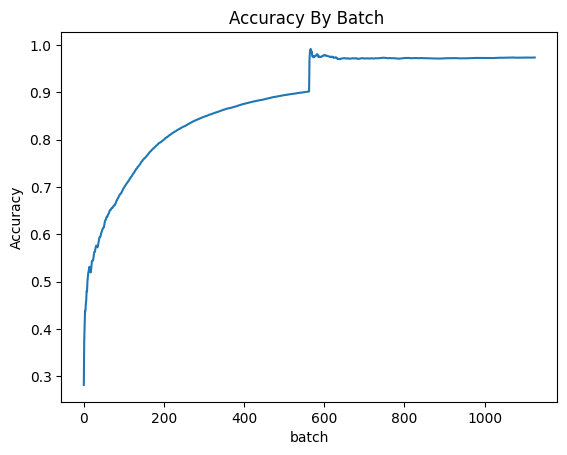

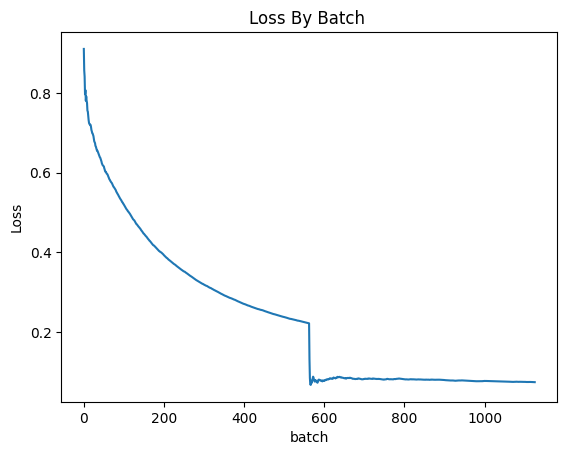

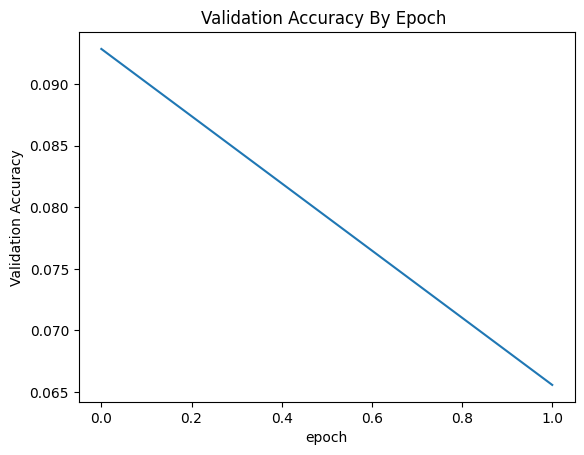

In [ ]:
import matplotlib.pyplot as plt

plt.plot(accuracy_result, label='Accuracy')
plt.xlabel('batch')
plt.ylabel('Accuracy')
plt.title('Accuracy By Batch ')
plt.show()

plt.plot(loss_result, label='Loss')
plt.xlabel('batch')
plt.ylabel('Loss')
plt.title('Loss By Batch ')
plt.show()

plt.plot(history.history['val_loss'], label='Validation Accuracy')
plt.xlabel('epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy By Epoch ')
plt.show()

In [ ]:
## Save the model which can be loaded later.
model.save('my_model.keras', overwrite=True)

In [ ]:
## Save the model which can be loaded later.
model.save('../gdrive/MyDrive/Colab_modules/my_model_keras', overwrite=True)